# Experiment - Compare BLS model performance with historical datasets and data aggregation.
This is an experimental idea that aggregate data points on longer time span than just one minute will improve performance and stability for any models other than RNN, especially in Fscore. It is based on the thinking: An anomaly should and can only be determined by the features acrossing a rather large time span. The features extracted from the messages within only one minute are not enough to determine if there is an anomaly in this minute of time.   
In this experiment, Aggregation of four time spans - 1, 5, 20, 60 - will be tested and the according mesurements (accuracy and fscore) will be compared.


In [85]:
# Switch between the following time spans to compare the results
time_span = 1
# time_span = 2
# time_span = 3
# time_span = 4
# time_span = 5
# time_span = 6
# time_span = 7
# time_span = 8
# time_span = 9
# time_span = 10
# time_span = 20
# time_span = 30
# time_span = 40
# time_span = 60


### 1. Select dataset

In [86]:
import numpy as np

# Load the datasets
path_app = "src"
dataset0 = np.loadtxt("./%s/data_historical/Code_Red_I.csv" % path_app, delimiter=",")
dataset1 = np.loadtxt("./%s/data_historical/Nimda.csv" % path_app, delimiter=",")
dataset2 = np.loadtxt("./%s/data_historical/Slammer.csv" % path_app, delimiter=",")
dataset3 = np.loadtxt("./%s/data_historical/Moscow_blackout.csv" % path_app, delimiter=",")
dataset4 = np.loadtxt("./%s/data_historical/WannaCrypt.csv" % path_app, delimiter=",")
dataset5 = np.loadtxt("./%s/data_historical/RIPE_regular.csv" % path_app, delimiter=",")
dataset6 = np.loadtxt("./%s/data_historical/BCNET_regular.csv" % path_app, delimiter=",")
datasets = {"Code_Red_I": dataset0, "Nimda": dataset1, "Slammer": dataset2, "Moscow_blackout": dataset3, "WannaCrypt": dataset4, "RIPE_regular": dataset5, "BCNET_regular": dataset6}

# Select datasets
raw_train_datasets = [datasets["Code_Red_I"], datasets["Nimda"]]
raw_test_dataset = datasets["Slammer"]

# raw_train_datasets = [datasets["Nimda"], datasets["Slammer"]]
# raw_test_dataset = datasets["Code_Red_I"]

# raw_train_datasets = [datasets["Slammer"], datasets["Code_Red_I"]]
# raw_test_dataset = datasets["Nimda"]

print("Raw training datasets shape: ", [x.shape for x in raw_train_datasets])
print("Raw training labels of regular and anomaly: ", [(np.sum(x[:,-1]==-1, axis=0), np.sum(x[:,-1]==1, axis=0)) for x in raw_train_datasets])
print("Raw test dataset shape: ", raw_test_dataset.shape)
print("Raw test labels of regular and anomaly: ", np.sum(raw_test_dataset[:,-1]==-1, axis=0), np.sum(raw_test_dataset[:,-1]==1, axis=0))
# print(raw_test_dataset[3206:3220, 4:16])
# print(raw_test_dataset[3206:3220, -1])

Raw training datasets shape:  [(7200, 42), (8609, 42)]
Raw training labels of regular and anomaly:  [(6600, 600), (7308, 1301)]
Raw test dataset shape:  (7200, 42)
Raw test labels of regular and anomaly:  6331 869


### 2. Aggregate data points
According to the feature definition, apply different aggregation function to different column.
```
Columns 1-4: time (column 1: hour+minute; column 2: hour; column 3: minute; column 4: second)
Columns 5-41: features

List of features extracted from BGP update messages:
1. Number of announcements
2. Number of withdrawals
3. Number of announced NLRI prefixes
4. Number of withdrawn NLRI prefixes
5. Average AS-path length
6. Maximum AS-path length
7. Average unique AS-path length
8. Number of duplicate announcements
9. Number of implicit withdrawals
10. Number of duplicate withdrawals
11. Maximum edit distance
12. Arrival rate [Number]
13. Average edit distance
14-23. Maximum AS-path length = n, where n = (11, ...,20)
24-33. Maximum edit distance = n, where n = (7, ...,16)
34. Number of Interior Gateway Protocol (IGP) packets
35. Number of Exterior Gateway Protocol (EGP) packets
36. Number of incomplete packets
37: Packet size (B) [Average]
```
This list comes from src/CSharp_Tool_BGP/Readme.md

In [87]:
import numpy as np

def aggregate_rows(arr, n):
    # Calculate the number of rows to keep to ensure the number of rows is a multiple of n
    rows_to_keep = (arr.shape[0] // n) * n
    arr = arr[:rows_to_keep]
    
    # Reshape the array to the shape (m/n, n, number of columns)
    reshaped = arr.reshape(-1, n, arr.shape[1])
    
    # Apply different aggregation functions to different columns
    coloumns_to_keep_the_first = [0, 1, 2, 3]
    columns_to_sum = [4, 5, 6, 7, 11, 12, 13, 15, 37, 38, 39]
    columns_to_mean = [8, 10, 16, 40]
    columns_to_max = [9, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]  
    aggregated = np.zeros((reshaped.shape[0], reshaped.shape[2]))
    aggregated[:, coloumns_to_keep_the_first] = reshaped[:, 0, coloumns_to_keep_the_first]  # Apply values of the first row in the group
    aggregated[:, columns_to_sum] = reshaped[:, :, columns_to_sum].sum(axis=1)
    aggregated[:, columns_to_mean] = reshaped[:, :, columns_to_mean].mean(axis=1)
    aggregated[:, columns_to_max] = reshaped[:, :, columns_to_max].max(axis=1)
    # aggregated[:, 41] = 100 if (np.sum(reshaped[:, :, 41] == 1, axis=1).all()/n) > 0.5 else -100 # Apply mean and round to the label
    aggregated[:, 41] = np.round(np.sum(reshaped[:, :, 41] == 1, axis=1)/n)*2-1  # Apply mean and round to the label
    
    return aggregated

def aggregate_datasets(datasets, time_span):
    aggregated_datasets = []
    for dataset in datasets:
        aggregated_datasets.append(aggregate_rows(dataset, time_span))
    return aggregated_datasets

train_datasets = aggregate_datasets(raw_train_datasets, time_span)
test_dataset = aggregate_rows(raw_test_dataset, time_span)

print("Aggregated training datasets shape: ", [x.shape for x in train_datasets])
print("Aggregated training labels of regular and anomaly: ", [(np.sum(x[:,-1]==-1, axis=0), np.sum(x[:,-1]==1, axis=0)) for x in train_datasets])
print("Aggregated test dataset shape: ", test_dataset.shape)
print("Aggregated test labels of regular and anomaly: ", np.sum(test_dataset[:,-1]==-1, axis=0), np.sum(test_dataset[:,-1]==1, axis=0))
# print(test_dataset[1603:1613, 4:16])
# print(test_dataset[1603:1613, -1])

Aggregated training datasets shape:  [(7200, 42), (8609, 42)]
Aggregated training labels of regular and anomaly:  [(6600, 600), (7308, 1301)]
Aggregated test dataset shape:  (7200, 42)
Aggregated test labels of regular and anomaly:  6331 869


### 3. Combine training dataset

In [88]:
def concatenate_datasets(datasets):
    result = datasets[0]
    for dataset in datasets[1:]:
        result = np.concatenate((result, dataset), axis=0)
    return result

train_dataset = concatenate_datasets(train_datasets)

print("Training dataset shape: ", train_dataset.shape)
print("Training labels of regular and anomaly: ", np.sum(train_dataset[:,-1]==-1, axis=0), np.sum(train_dataset[:,-1]==1, axis=0))
print("Test dataset shape: ", test_dataset.shape)
print("Test labels of regular and anomaly: ", np.sum(test_dataset[:,-1]==-1, axis=0), np.sum(test_dataset[:,-1]==1, axis=0))


Training dataset shape:  (15809, 42)
Training labels of regular and anomaly:  13908 1901
Test dataset shape:  (7200, 42)
Test labels of regular and anomaly:  6331 869


### 4. Data normalization

In [89]:
import sys
sys.path.append('./src/VFBLS_v110')
from bls.processing.replaceNan import replaceNan

def normalizate(dataset, div = 1 ):
    row_index_end = dataset.shape[0] - dataset.shape[0] % div  # divisible by div, but What is div for?
    data_x = dataset[:row_index_end, 4:-1]
    replaceNan(data_x)  # Replace "nan" with 0
    data_y = dataset[:row_index_end, -1]
    # Change training labels
    inds1 = np.where(data_y == -1)
    data_y[inds1] = 2
    return data_x,data_y

train_x, train_y = normalizate(train_dataset)
test_x, test_y = normalizate(test_dataset)

print("Training dataset shape: ", train_x.shape)
print("Training labels of regular and anomaly: ", np.sum(train_y==2), np.sum(train_y==1))
print("Test dataset shape: ", test_x.shape)
print("Test labels of regular and anomaly: ", np.sum(test_y==2), np.sum(test_y==1))


Training dataset shape:  (15809, 37)
Training labels of regular and anomaly:  13908 1901
Test dataset shape:  (7200, 37)
Test labels of regular and anomaly:  6331 869


### 5. Training and testing

In [90]:
from src.VFBLS_v110.bls.processing.one_hot_m import one_hot_m
from src.VFBLS_v110.bls.model.bls_train import bls_train_realtime

print("======================= BLS =======================\n")
def train_test(train_x, train_y, test_x):
    # Set parameters
    mem = 'low'
    # mem = 'high'
    # BLS parameters
    seed = 1  # set the seed for generating random numbers
    num_class = 2  # number of the classes
    epochs = 1  # number of epochs
    C = 2 ** -15  # parameter for sparse regularization
    s = 0.6  # the shrinkage parameter for enhancement nodes
    train_y = one_hot_m(train_y, num_class)
    # test_y = one_hot_m(test_y, num_class);
    #######################
    # N1* - the number of mapped feature nodes
    # N2* - the groups of mapped features
    # N3* - the number of enhancement nodes
    if mem == 'low':
        N1_bls = 20
        N2_bls = 5
        N3_bls = 100
    else:
        N1_bls = 200
        N2_bls = 10
        N3_bls = 100
    #######################

    train_err = np.zeros((1, epochs))
    train_time = np.zeros((1, epochs))
    test_time = np.zeros((1, epochs))
    np.random.seed(seed)  # set the seed for generating random numbers
    for j in range(0, epochs):
        trainingAccuracy, trainingTime, testingTime, predicted = \
        bls_train_realtime(train_x, train_y, test_x,
                            s, C,
                            N1_bls, N2_bls, N3_bls)

        train_err[0, j] = trainingAccuracy * 100
        train_time[0, j] = trainingTime
        test_time[0, j] = testingTime
    # predicted = [[1.], [2.], [2.], [2.], [2.]]
    predicted_list = []
    for label in predicted:
        predicted_list.append(label[0])
    return predicted_list

predicted_list = train_test(train_x, train_y, test_x)

print("predicted_list:", predicted_list)


======================= BLS =======================

Feature nodes in window  0 : Max Val of Output  239.0782198278995  Min Val  -182.1156926967011
Feature nodes in window  1 : Max Val of Output  83.35637012688804  Min Val  -51.953658847991264
Feature nodes in window  2 : Max Val of Output  119.89981889767027  Min Val  -141.31036419809777
Feature nodes in window  3 : Max Val of Output  62.22415428296303  Min Val  -39.12965870216625
Feature nodes in window  4 : Max Val of Output  34.224184768289184  Min Val  -64.65038872711611
Enhancement nodes: Max Val of Output  0.27226760875315187  Min Val  -1.6738468920240206
Training has been finished!
The Total Training Time is :  0.34688496589660645  seconds
xx.shape (15809, 2)
xx [[ 0.01243196  0.98756704]
 [ 0.01322157  0.98677786]
 [ 0.03424603  0.96575298]
 ...
 [ 0.02960162  0.97039807]
 [ 0.01127756  0.98872113]
 [-0.01337702  1.01337665]]
Training Accuracy is :  92.320829907015  %
Testing has been finished!
The Total Testing Time is :  0.0

### 6. Accuracy and Fscore

In [91]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_y, predicted_list)
fscore = f1_score(test_y, predicted_list)

print(f"Accuracy: {accuracy:.2%}, Fscore: {fscore:.2%}")

Accuracy: 95.46%, Fscore: 78.13%


### 7. Integrated run


#### 7.1 Run with batch parameters

In [92]:
import os

def blockPrint():
    old_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    return old_stdout
def enablePrint(old_stdout):
    sys.stdout = old_stdout

time_span_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]
# time_span_list = [1, 2, 3]
data_combos = [{"train": ["Code_Red_I", "Nimda"], "test": "Slammer"},
                {"train": ["Nimda", "Slammer"], "test": "Code_Red_I"},
                {"train": ["Slammer", "Code_Red_I"], "test": "Nimda"}]
results = []
for combo in data_combos:
    print(f"Data combo: {combo}")
    for time_span in time_span_list:
        raw_train_datasets = []
        for name in combo["train"]:
            raw_train_datasets.append(datasets[name])
        train_datasets = aggregate_datasets(raw_train_datasets, time_span)
        test_dataset = aggregate_rows(datasets[combo["test"]], time_span)
        train_dataset = concatenate_datasets(train_datasets)
        train_x, train_y = normalizate(train_dataset)
        test_x, test_y = normalizate(test_dataset)
        old_stdout = blockPrint()
        predicted_list = train_test(train_x, train_y, test_x)
        enablePrint(old_stdout)
        accuracy = accuracy_score(test_y, predicted_list)
        fscore = f1_score(test_y, predicted_list)
        row = ["+".join(combo["train"]), combo["test"], f"{time_span}", f"{accuracy*100:.2f}", f"{fscore*100:.2f}"]
        # row = ["+".join(combo["train"]), combo["test"], time_span, accuracy*100, fscore*100]
        results.append(row)
        print(f"Time span: {time_span} - Accuracy: {accuracy:.2%}, Fscore: {fscore:.2%}")

# Save the results
file_name = "src/STAT/xpr_results.csv" 
# np.savetxt("xpr_results.csv", results, delimiter=",", fmt="%s,%s,%f,%f,%f")
results.insert(0, ["Train datasets", "Test datasets", "Time span", "Accuracy %", "Fscore %"])
results = np.array(results)
np.savetxt(file_name, results, delimiter=",", fmt="%s")
print("Results saved to", file_name)

Data combo: {'train': ['Code_Red_I', 'Nimda'], 'test': 'Slammer'}
Time span: 1 - Accuracy: 95.46%, Fscore: 78.13%
Time span: 2 - Accuracy: 95.94%, Fscore: 80.89%
Time span: 3 - Accuracy: 96.08%, Fscore: 81.57%
Time span: 4 - Accuracy: 95.78%, Fscore: 79.57%
Time span: 5 - Accuracy: 96.04%, Fscore: 80.94%
Time span: 6 - Accuracy: 95.92%, Fscore: 80.00%
Time span: 7 - Accuracy: 95.04%, Fscore: 75.60%
Time span: 8 - Accuracy: 94.89%, Fscore: 74.73%
Time span: 9 - Accuracy: 95.88%, Fscore: 80.00%
Time span: 10 - Accuracy: 95.97%, Fscore: 80.54%
Time span: 20 - Accuracy: 95.00%, Fscore: 75.68%
Time span: 30 - Accuracy: 93.75%, Fscore: 71.70%
Data combo: {'train': ['Nimda', 'Slammer'], 'test': 'Code_Red_I'}
Time span: 1 - Accuracy: 94.58%, Fscore: 62.06%
Time span: 2 - Accuracy: 95.17%, Fscore: 65.75%
Time span: 3 - Accuracy: 95.17%, Fscore: 66.08%
Time span: 4 - Accuracy: 95.50%, Fscore: 69.20%
Time span: 5 - Accuracy: 95.69%, Fscore: 68.04%
Time span: 6 - Accuracy: 95.00%, Fscore: 62.96%
T

#### 7.2 Plot the result

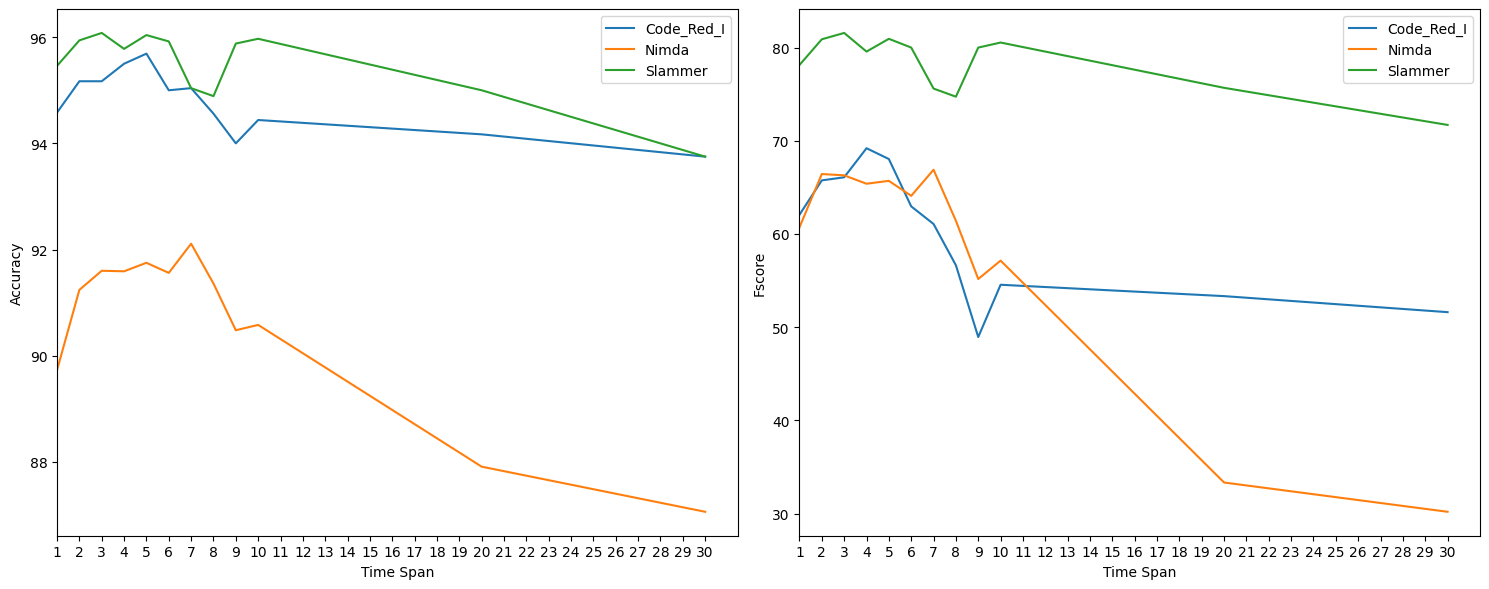

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Extract unique series
unique_series = np.unique(results[1:, 1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot each series for Accuracy
for series in unique_series:
    mask = np.array([row[1] == series for row in results])
    ts = results[mask, 2].astype(int)
    accuracy = results[mask, 3].astype(float)
    ax1.plot(ts, accuracy, label=series)

# Plot each series for Fscore
for series in unique_series:
    mask = np.array([row[1] == series for row in results])
    ts = results[mask, 2].astype(int)
    fscore = results[mask, 4].astype(float)
    ax2.plot(ts, fscore, label=series)

# Set x-axis limits to start from 1 and set ticks
ax1.set_xlim(left=1)
ax2.set_xlim(left=1)
ax1.set_xticks(range(1, max(results[1:, 2].astype(int)) + 1))
ax2.set_xticks(range(1, max(results[1:, 2].astype(int)) + 1))

# Set labels and legends
ax1.set_xlabel('Time Span')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.set_xlabel('Time Span')
ax2.set_ylabel('Fscore')
ax2.legend()

plt.tight_layout()
plt.show()